In [1]:

import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from data import fut_list, fut_read, stock_read, pair
from util import adf_test, data_generator, significant, johansen_cointegration_test, EG, benefits_show
import warnings
warnings.filterwarnings("ignore")


# Config

In [2]:

fut = fut_list[0]
feature = 'ChangeRatio'
OUTPUT_PATH = './output'
fut
# fut_list

'CU9999.XSGE'

# DATA
* 数据基础已经全部存在data里了。只需进一步处理得到想要的时间序列。

In [3]:
fut_df = fut_read(fut)
stock_df = stock_read(fut)

### 如果想要定制特征，处理fut_df \ stock_df即可。

# ADF验证是否平稳

In [91]:
adf_list = []
for idx, df in enumerate(stock_df):
   adf_list.append(adf_test(df[feature]))
adf_list.append(adf_test(fut_df[feature]))
adf_df = pd.concat(adf_list, axis=1)   
adf_df = adf_df.T
del adf_df['Number of Observations Used']
adf_df
with open(f'{OUTPUT_PATH}/adf_test.txt', 'a') as f:
   f.write(fut + '\n')
   f.write('\n')
adf_df.to_csv(f'{OUTPUT_PATH}/adf_test.txt', mode='a')


对于changeratio而言，是平稳的

# 根据模型找出各个stock的联动显著时间段
* 由于只有VAR，故不再对模型选择进行分支。
* 由于p=0.05基本找不到显著的时间段，改成了0.10
* y是股票的y。第一个p是const的，第二个是期货前一时刻特征的p，第三个是股票前一时刻的特征的p。

## 先算一下相关性
* 这个只算了一个期货和具体股票某个特征的收益。
* 看下面收益率的corr，相关性还挺高。
* 与此同时，把数据的describe也写上了。

In [87]:
corr_list = []
data_describe = []
for idx, df in enumerate(stock_df):
    data, label = data_generator(fut_df, df, feature)
    with open(f"{OUTPUT_PATH}/corr.txt", "a") as f:
        f.write(f"期货名{fut}")
        f.write('\n')
        f.write(f"股票名:{pair[fut][idx]}")
        f.write('\n')
        f.write(str(data.corr()) + '\n')
        f.write('\n')
        f.write('\n')
    with open(f"{OUTPUT_PATH}/describe.txt", "a") as f:
        f.write(f"期货名{fut}")
        f.write('\n')
        f.write(f"股票名:{pair[fut][idx]}")
        f.write('\n')
        f.write(str(data.describe()) + '\n')
        f.write('\n')
        f.write('\n')
# data_describe

#### 主意这个找显著，都是90%置信读就行。因为95%的找不到。

In [10]:
feature = 'ChangeRatio'
sig_col = []
for idx, df in enumerate(stock_df):
    data, label = data_generator(fut_df, df, feature)
    sig_col.append(significant(data))
sig_col
# 要画什么图根据这个再改一改。

[([[445, array([0.06187387, 0.01776586, 0.09157615])],
   [446, array([0.07216438, 0.01201078, 0.06453823])],
   [527, array([0.09130337, 0.00218921, 0.0152069 ])],
   [830, array([0.04396597, 0.08938499, 0.0434864 ])],
   [831, array([0.02516317, 0.07404043, 0.03527982])]],
  []),
 ([[117, array([0.04668035, 0.09926507, 0.06327435])],
   [118, array([0.07776827, 0.03992777, 0.04845521])],
   [119, array([0.06423892, 0.03505261, 0.05556232])],
   [121, array([0.09273869, 0.0355535 , 0.07064869])],
   [122, array([0.09610814, 0.03836194, 0.07086439])],
   [236, array([0.02002243, 0.0120848 , 0.01287456])],
   [337, array([0.00793185, 0.09517341, 0.05815873])],
   [704, array([0.03831802, 0.06976187, 0.06859907])],
   [710, array([0.05944347, 0.09346452, 0.07455753])],
   [711, array([0.07820956, 0.00994392, 0.06824263])],
   [940, array([0.07264779, 0.00819468, 0.09051487])],
   [941, array([0.07016725, 0.01477812, 0.09029967])]],
  []),
 ([[241, array([0.00204869, 0.07670813, 0.0677163

上面sig为list。list 0-4表明对应的stock。

比如list[0]中，就存了期股联动显著的时间切片。list中第一个数字是时间切片编号，第二个是三个p。p的解释如上

sig_col 即为显著的index

还有更进一步的算最佳lead lag,不过都是1，所以似乎不重要了,写在下面。可以尝试下冲击

```python
lag_order = model.select_order(15)
print(f"Selected lag order: {lag_order.selected_orders['aic']}")
model_fitted = model.fit(maxlags=lag_order.selected_orders['aic'])
print(model_fitted.summary())

irf = model_fitted.irf(10) # 10期冲击响应
irf.plot(orth=True) # 正交化冲击响应图
plt.show()

```

# VAR 冲击效应

Selected lag order: 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 15, Apr, 2024
Time:                     21:01:45
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -16.5840
Nobs:                     1172.00    HQIC:                  -16.6109
Log likelihood:           6427.54    FPE:                6.01036e-08
AIC:                     -16.6272    Det(Omega_mle):     5.95940e-08
--------------------------------------------------------------------
Results for equation ChangeRatio_Future
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.000353         0.000321            1.100           0.271
L1.ChangeRatio_Future        -0.085180         0.033901           -2.513          

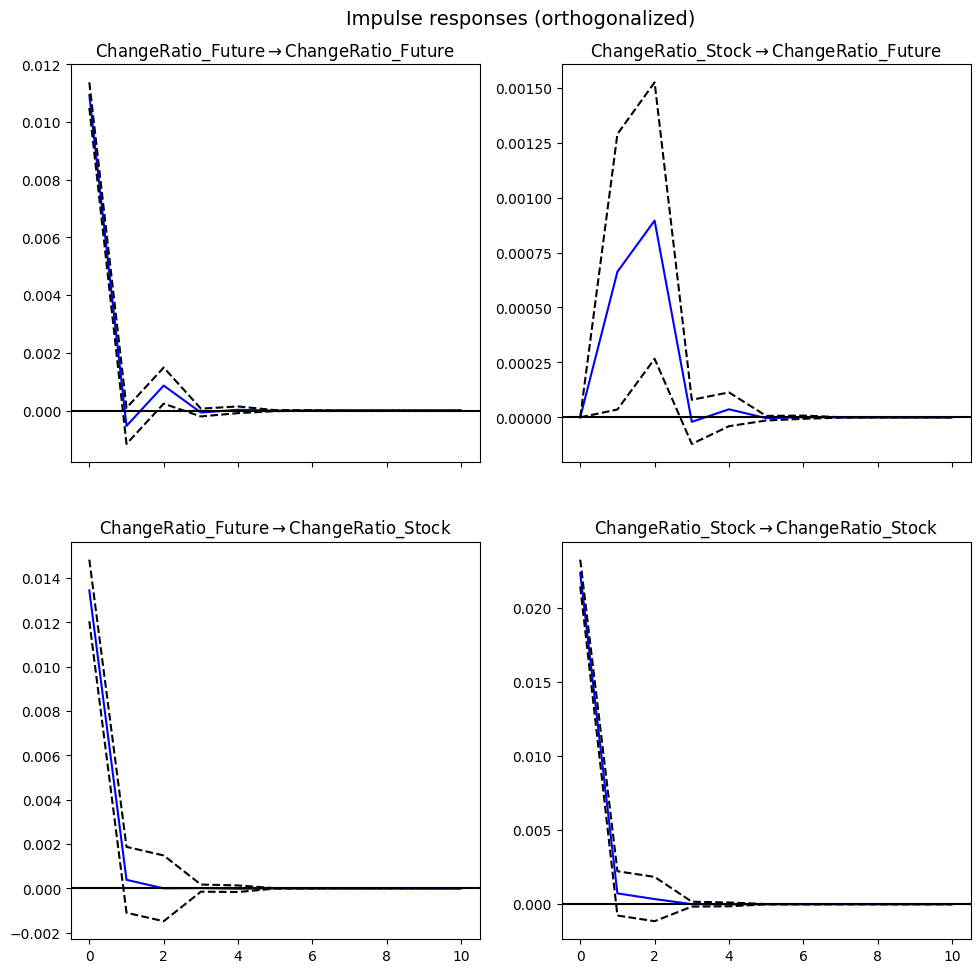

In [7]:
feature = 'ChangeRatio'
data, label = data_generator(fut_df, stock_df[0], feature)
model = VAR(data)
lag_order = model.select_order(15)
print(f"Selected lag order: {lag_order.selected_orders['aic']}")
model_fitted = model.fit(maxlags=lag_order.selected_orders['aic'])
print(model_fitted.summary())

irf = model_fitted.irf(10) # 10期冲击响应
irf.plot(orth=True) # 正交化冲击响应图
plt.show()

# 画图

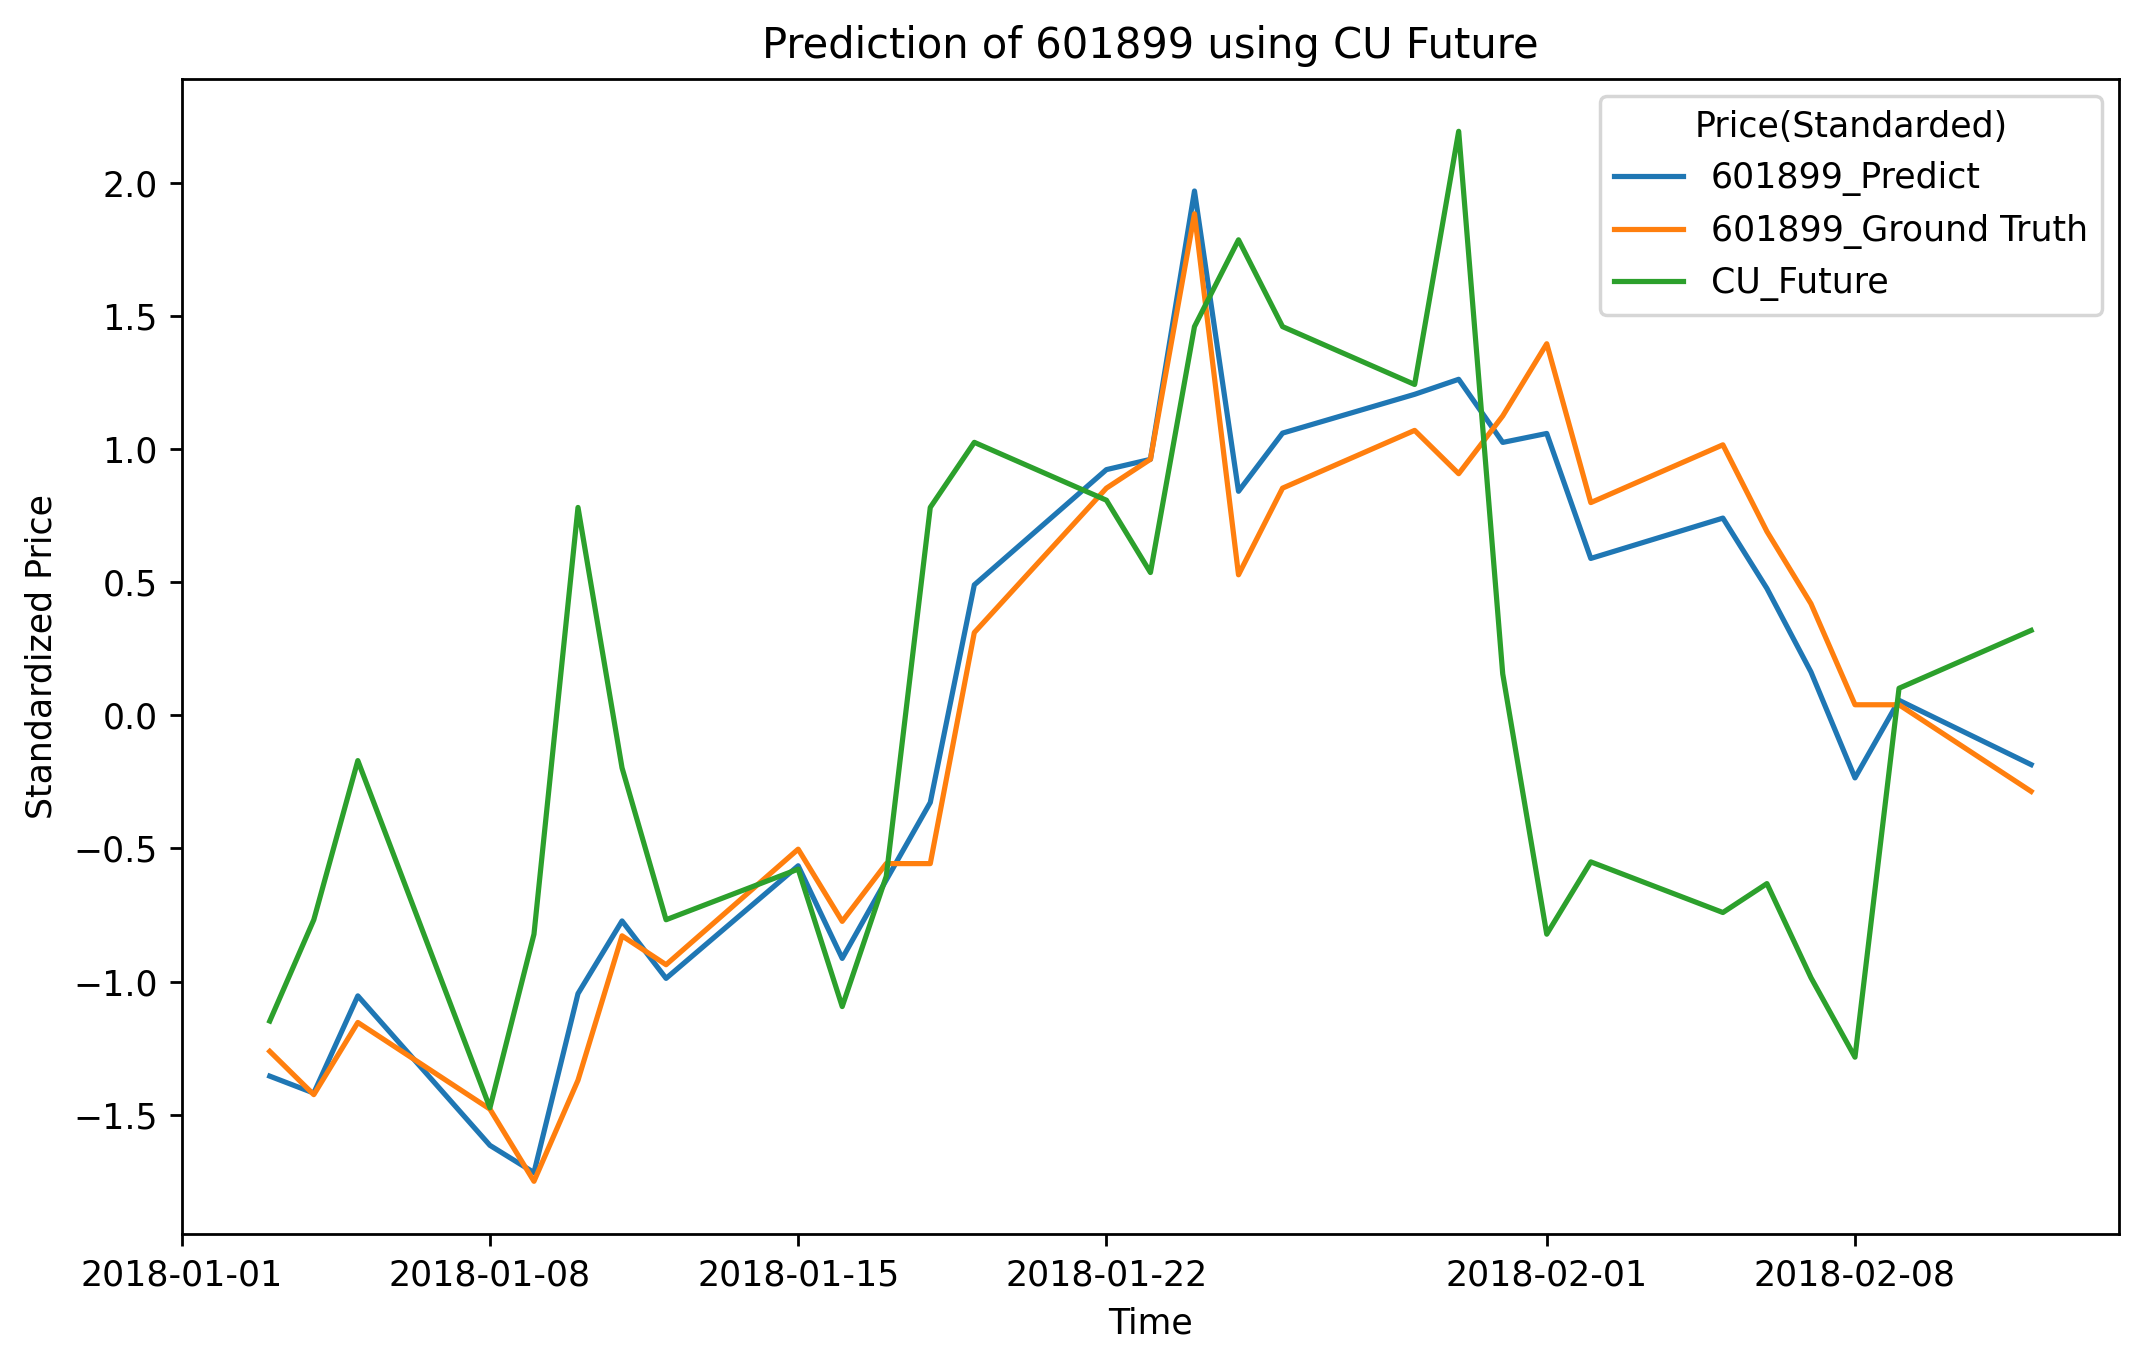

In [4]:
feature = 'close'
data, label = data_generator(fut_df, stock_df[0], feature)
fig = benefits_show(0, data, fut_df)
# fig

# 协整检验
* 只用检验上面的data数据（就是一列是期货数据，一列是股票数据）

!! 只看一次，所以只用了一个break

In [71]:
# print('Results of Johansen Cointegration Test:')
# print(f"Test statistic: {result.lr1}")
# print(f"Critical values: {result.cvt}")
# print(f"Eigenstatistics: {result.lr2}")
# print(f"Eigenvalues: {result.eig}")
Test_statistic = []
Critical_values = []
Eigenstatistic = []
Eigenvalues = []
for idx, df in enumerate(stock_df):
    data = data_generator(fut_df, df, feature)
    test_result = johansen_cointegration_test(data[0])
    Test_statistic.append(test_result.lr1)
    Critical_values.append(test_result.cvt)
    Eigenstatistic.append(test_result.lr2)
    Eigenvalues.append(test_result.eig)

# 可以很方便的改成df

In [77]:
Critical_values
# pd.DataFrame(Critical_values)

[array([[10.4741, 12.3212, 16.364 ],
        [ 2.9762,  4.1296,  6.9406]]),
 array([[10.4741, 12.3212, 16.364 ],
        [ 2.9762,  4.1296,  6.9406]]),
 array([[10.4741, 12.3212, 16.364 ],
        [ 2.9762,  4.1296,  6.9406]]),
 array([[10.4741, 12.3212, 16.364 ],
        [ 2.9762,  4.1296,  6.9406]]),
 array([[10.4741, 12.3212, 16.364 ],
        [ 2.9762,  4.1296,  6.9406]])]

# VAR回归系数

In [11]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from data import fut_list, fut_read, stock_read, pair
from util import adf_test, data_generator, significant, johansen_cointegration_test, EG, benefits_show
feature = 'ChangeRatio'
# sign = [0, 3, 161, 10, 6]  #这个对应close
sign = [445, 117, 241, 233, 1042]
for idx, df in enumerate(stock_df):
    data, label = data_generator(fut_df, df, feature)
    significant_idx= sign[idx]
    window_size = 30
    window_start = significant_idx
    window_end = significant_idx + window_size
    window_data = data.iloc[window_start:window_end]
    model = VAR(window_data)
    results = model.fit()
    results.params
    with open(f'{OUTPUT_PATH}/params.txt', 'a') as file:
        file.write(f"# feature: {feature}\n")
        file.write(f"# 期货{fut}\n")
        file.write(f"# 股票{pair[fut][idx]}\n")
        file.write(f"significant_idx:{significant_idx}\n")
        file.write("\n")
        results.params.round(2).to_csv(file, sep='\t')
        file.write("\n")
    

# E-G协整检验

* 对回归残差的检验

* result是股票对期货回归得到的模型的参数。比如t值 p值 r^2等

In [7]:
result_list = []
output_list = []
for df in stock_df:
    data, label = data_generator(fut_df, df, feature)
    result_df, output = EG(data)
    result_list.append(result_df)
    output_list.append(output)
output_list

[Test Statistic                -7.815830e+00
 p-value                        6.874476e-12
 #Lags Used                     1.600000e+01
 Number of Observations Used    1.177000e+03
 Critical Value (1%)           -3.435918e+00
 Critical Value (5%)           -2.863999e+00
 Critical Value (10%)          -2.568079e+00
 dtype: float64,
 Test Statistic                -1.238469e+01
 p-value                        4.939421e-23
 #Lags Used                     6.000000e+00
 Number of Observations Used    1.187000e+03
 Critical Value (1%)           -3.435871e+00
 Critical Value (5%)           -2.863978e+00
 Critical Value (10%)          -2.568068e+00
 dtype: float64,
 Test Statistic                  -31.417415
 p-value                           0.000000
 #Lags Used                        0.000000
 Number of Observations Used    1193.000000
 Critical Value (1%)              -3.435843
 Critical Value (5%)              -2.863966
 Critical Value (10%)             -2.568061
 dtype: float64,
 Test Stati

# VECM

### 下面这个是VAR的

下面表明最好的lag一般是1

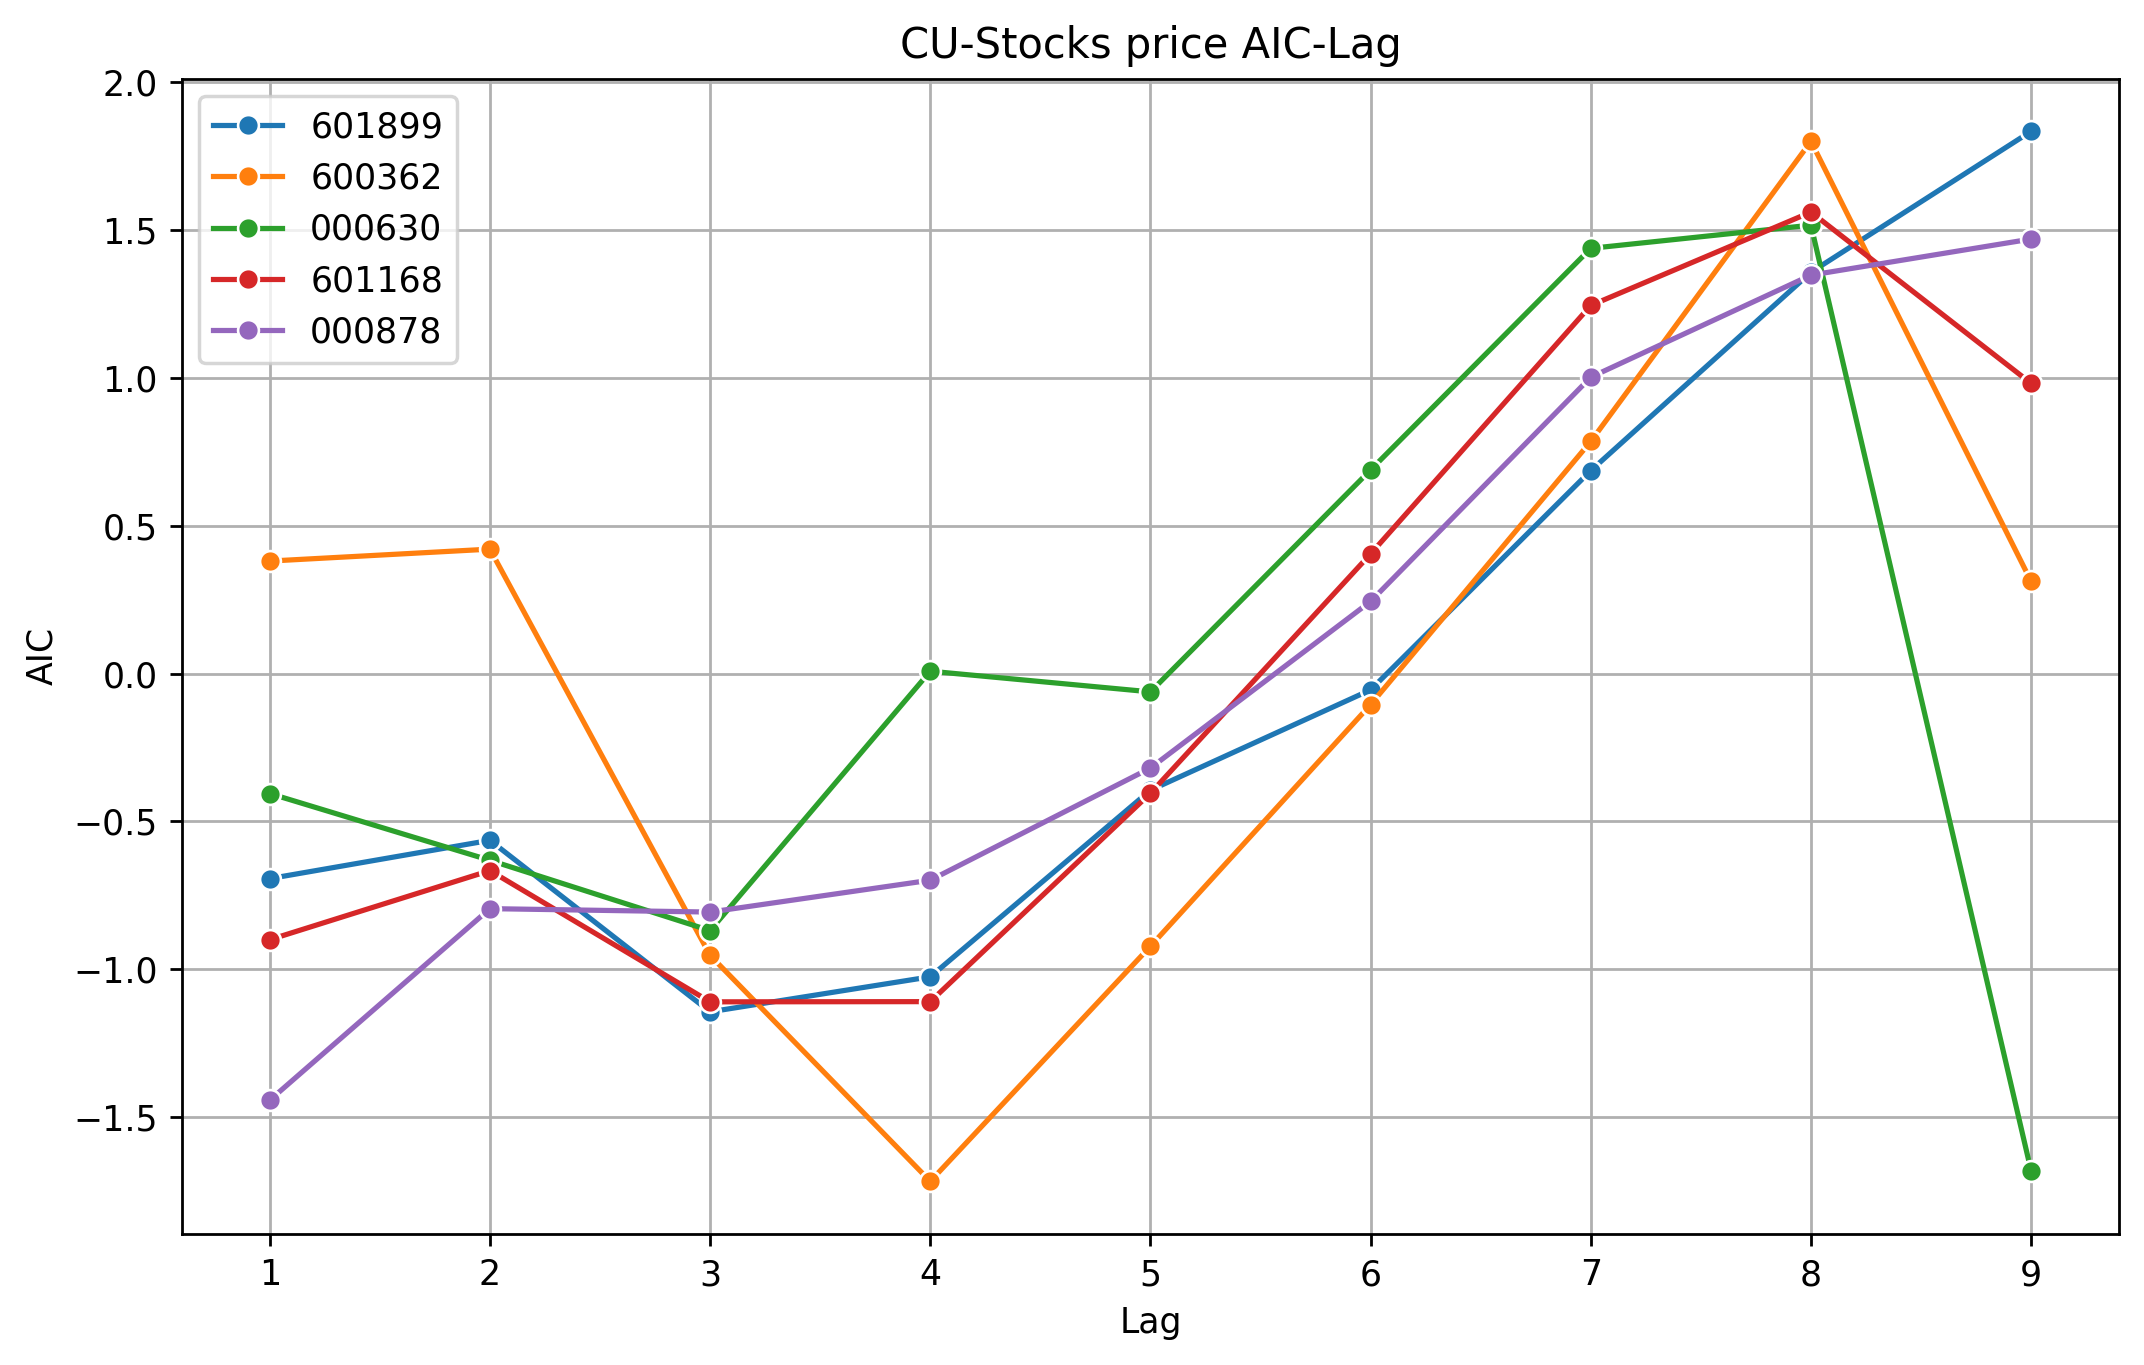

In [35]:
feature = 'close'
plt.figure(figsize=(10, 6), dpi=250)
ans = []
for idx, df in enumerate(stock_df):
    aic_values = []
    data, label = data_generator(fut_df, df, feature)

    for lag in range(1, 10):
        model = VAR(data)
        results = model.fit(lag)
        aic = results.aic
        aic_values.append(aic)
    df = pd.DataFrame({'Lag': np.linspace(1,9,9), 'AIC': aic_values})

    import seaborn as sns
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    df['AIC'] = scaler.fit_transform(df[['AIC']])
    ans.append(df['AIC'])
    sns.lineplot(data=df, x='Lag', y='AIC', marker='o', label= f'{pair[fut][idx]}')
    plt.title(f'{fut[:2]}-Stocks price AIC-Lag')
    plt.xlabel('Lag')
    plt.ylabel('AIC')
    plt.grid(True)
ans = pd.concat(ans, axis=1)
ans = ans.round(2)
ans.columns = [pair[fut][i] for i in range(len(stock_df))]
ans.to_csv(f"{OUTPUT_PATH}/VAR_AIC_{feature}.csv")
plt.legend() 
plt.savefig(f'{OUTPUT_PATH}/{fut[:2]}-Stocks price AIC-Lag.png')

## 求AIC

In [13]:
ans = pd.DataFrame()
feature = 'close'
for idx, df in enumerate(stock_df):
    data, label = data_generator(fut_df, df, feature)
    aic_values = []
    for lag in range(1, 10):
        model = VAR(data)
        results = model.fit(lag)
        aic_values.append(results.aic)
    tmp = pd.DataFrame( {f'AIC_stock{idx+1}': aic_values}).T
    ans = pd.concat([ans, tmp], axis=0)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for idx in ans.index:
    ans.loc[idx] = scaler.fit_transform(ans.loc[idx].values.reshape(-1, 1)).reshape(-1)
ans = ans.round(2)
ans.index = [pair[fut][idx] for idx in range(len(stock_df))]
ans.to_csv(f'{OUTPUT_PATH}/VAR_AIC_close.csv')
# scaled.index = [pair[fut][idx] for idx in range(len(stock_df))]
# scaled.to_csv(f'{OUTPUT_PATH}/VAR_AIC_{feature}.csv')

## 求统计量

In [39]:
feature = 'close'
data, label = data_generator(fut_df, stock_df[0], feature)
model = VAR(data)
results = model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 15, Apr, 2024
Time:                     23:17:10
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    9.89792
Nobs:                     1172.00    HQIC:                   9.87099
Log likelihood:          -9090.84    FPE:                    19047.4
AIC:                      9.85469    Det(Omega_mle):         18885.9
--------------------------------------------------------------------
Results for equation close_Future
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                 553.191816       188.760557            2.931           0.003
L1.close_Future         0.917343         0.034542           26.557           0.000
L1.close_Stock        207.777277        95.45

## 求系数

In [37]:
beta_list = []
feature = 'close'
for idx, df in enumerate(stock_df):
    data, label = data_generator(fut_df, df, feature)
    model = VAR(data)
    results = model.fit(2)
    beta_list.append(results.params[f'{feature}_Stock'].round(5))
beta_df = pd.concat(beta_list, axis=1)
beta_df.columns = [pair[fut][idx] for idx in range(len(stock_df))]
beta_df.to_csv(f'{OUTPUT_PATH}/VARs_beta_Regrad_stock_as_y(result)——{feature}.csv')

### 下面这个是VECM

In [19]:
from statsmodels.tsa.vector_ar.vecm import VECM, select_order
vecm_list = []
for df in stock_df:
    data, label = data_generator(fut_df, df, feature)
    lag_order = select_order(data=data, maxlags=10, deterministic="ci").selected_orders['aic']
    print(f"Selected lag order by AIC: {lag_order}")
    vecm = VECM(endog=data, k_ar_diff=lag_order, coint_rank=1, deterministic="ci")
    vecm_fitted = vecm.fit()
    vecm_list.append(vecm_fitted)


Selected lag order by AIC: 1
Selected lag order by AIC: 2
Selected lag order by AIC: 1
Selected lag order by AIC: 1
Selected lag order by AIC: 2


可能还需要看的就是VECM表中对应的信息是啥意思了。

In [ ]:
vecm_list

！！！牛魔这个每个lag对应的AIC实在找不到方法求。VECM没有提供AIC的功能，select_order只返回一个最好的lag的AIC。想画图画布不了。放弃了。

# 试着算VCM的胜率

* sig_list跟之前的sig_col是一个意思。表示显著的时间。
* acc_list则是每个时间切片的胜率。我们可以根据sig_list中显著时间对应的index直接在acc_list中找。

In [7]:
sig_list = []
acc_list = []
for idx, df in enumerate(stock_df):
    data, label = data_generator(fut_df, df, feature)
    sig, acc = significant(data, label)
    sig_list.append(sig)
    acc_list.append(acc)


下面举个例子。可以看到胜率是0.73333

In [19]:
# 举个例子 改sig_list第二个索引
idx = sig_list[0][5][0]
win = acc_list[0][idx]
win

0.7333333333333333

# Granger

In [5]:
def granger(data):
    result = sm.tsa.stattools.grangercausalitytests(data, maxlag=2, verbose=False)
    p_value = result[1][0]['params_ftest'][0:2]
    return p_value

In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

for idx, df in enumerate(stock_df):
    data, label = data_generator(fut_df, df, feature)
    p_value = granger(data)
    with open('granger.txt', 'a') as file:
        file.write(f"Granger causality test for {fut}:" + "\n")
        file.write(f"Granger causality test for {pair[fut][idx]}:" + "\n")
        file.write(f"t_value: {p_value[0].round(2)}" + "\n")
        file.write(f"p_value: {p_value[1].round(2)}" + "\n")
        file.write("\n")
        if p_value[1] < 0.05:
            file.write(f"Granger 因果检验：{fut}对 {pair[fut][idx]}有因果关系")
        else:
            file.write(f"Granger 因果检验：{fut} 对 {pair[fut][idx]} 无因果关系")
            
        file.write("\n")
        file.write("\n")
        file.write("\n")
        file.write("\n")
